In [ ]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline
plt.style.use('default')


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time
import scipy as sc

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.GRF_inhomogeneities_class import *
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class
from GRF_perturbations.Modules.Utils import scipy_fit_Surface_Brightness,jax_map
from GRF_perturbations.Modules.Inference_class import Inference_class

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(8)

#Fontsize
FS=18

# Test Inference

In [ ]:
GRF_class=GRF_inhomogeneities_class(100, 0.08, 400)
Surface_brightness=Surface_brightness_class(100,0.08,0.1,200,2028)
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=2)

In [ ]:
data_spec=Inference.Anomalies_Radial_Power_Spectrum([-7.8, 2],GRF_class.tensor_unit_Fourier_images[0])
plt.loglog(Surface_brightness.frequencies,data_spec)

## Optimization of GRF power spectrum

In [ ]:
import time
def Spectra_Loss_Chi_sq(model_spectra,data_spectrum,Number_of_spectra):

    data_log_spectrum=jnp.log(data_spectrum)
    models_log_spectra=jnp.log(model_spectra)

    Mean_logN=models_log_spectra.mean(axis=-2)
    Sigma_logN=jnp.sqrt(jnp.power(models_log_spectra-Mean_logN,2).sum(axis=-2)/(Number_of_spectra-1))

    #Chi^2 loss for Normal likelihood of log(Power_spectrum)
    return jnp.mean(jnp.power((data_log_spectrum - Mean_logN)/Sigma_logN, 2), axis=-1)

In [ ]:
Number_of_spectra=400
Spectra_Loss_function=lambda model_spectra: Spectra_Loss_Chi_sq(model_spectra,data_spec,Number_of_spectra)
GRF_Loss=jax.jit(lambda GRF_params: Inference.GRF_Power_Spectrum_Loss(GRF_params,Number_of_spectra,Spectra_Loss_function,fit_image=False))
GRF_grad_Loss=jax.jit(jax.grad(GRF_Loss))
GRF_hessian_Loss=jax.jit(jax.jacfwd(jax.jacrev(GRF_Loss)))

In [ ]:
start_time=time.time()
print('loss',GRF_Loss([-7.6,2.]),'time',time.time()-start_time)

In [ ]:
start_time=time.time()
print('grads',GRF_grad_Loss([-7.6,2.]),'time',time.time()-start_time)

In [ ]:
start_time=time.time()
print('grads',GRF_hessian_Loss([-7.6,2.]),'time',time.time()-start_time)

In [ ]:
import scipy
Nfeval = 1
history=np.zeros((0,2))
loss_history=np.zeros(0)
bounds=((-10.075, -6.9), (0., 4.7))
initial_args=[-10.,3.]

def callbackF_trust_constr(Xi,optimizer):
    global Nfeval
    global history
    global loss_history

    if Nfeval==1:
        print(' step      logA        Beta        Loss       dL/dlA        dL/dB')

    loss=GRF_Loss(Xi)
    grad=GRF_grad_Loss(Xi)
    print('{0:4d}      {1:3.3f}      {2: 3.3f}      {3: 3.3f}      {4: 3.3f}      {5: 3.3f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))

    Nfeval += 1
    loss_history=np.append(loss_history,optimizer.fun)
    history=np.append(history,[Xi],axis=0)

res=scipy.optimize.minimize(GRF_Loss,initial_args,method='trust-constr',jac=GRF_grad_Loss,hess=GRF_hessian_Loss,
                            bounds=bounds,options={'disp': True},callback=callbackF_trust_constr,tol=0.001)

In [ ]:
getter_SB_Anomalies_spectra=jax.jit(lambda unit_Fourier_image: Inference.Anomalies_Radial_Power_Spectrum(res.x,unit_Fourier_image, Noise_flag=True,fit_image=False))
SB_Anomalies_spectra=jax_map(getter_SB_Anomalies_spectra,GRF_class.tensor_unit_Fourier_images)

Mean_logN=np.log(SB_Anomalies_spectra).mean(axis=-2)
Sigma_logN=jnp.sqrt(jnp.power(np.log(SB_Anomalies_spectra)-Mean_logN,2).sum(axis=-2)/(len(SB_Anomalies_spectra)-1))

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(10,7),sharex=True)
ax[0].plot(Surface_brightness.frequencies,np.log(data_spec),label='data')
ax[0].errorbar(Surface_brightness.frequencies,Mean_logN,Sigma_logN,capsize=2,label='model')
ax[0].set_ylabel('Power')
ax[0].set_xscale('log')
ax[0].legend(loc='lower left')

Chi_sq=jnp.power((np.log(data_spec)-Mean_logN)/Sigma_logN,2)*np.sign(np.log(data_spec)-Mean_logN)
ax[1].plot(Surface_brightness.frequencies,Chi_sq,label='Residuals')
ax[1].errorbar(Surface_brightness.frequencies,np.zeros_like(Chi_sq),np.ones_like(Chi_sq),capsize=2,alpha=0.5,label='Model')
ax[1].set_xscale('log')
ax[1].set_xlabel('log(Frequency), '+r'$arcsec^{-1}$')
ax[1].set_ylabel(r'$\chi^2$')
ax[1].legend(loc='lower left')

fig.suptitle('Fit results',fontsize=FS)
plt.show()

In [ ]:
hessian=GRF_hessian_Loss(res.x)
fisher_matrix = jnp.linalg.inv(hessian)

In [ ]:
sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.xticks(range(2), ['logA',r'$\beta$'], rotation='vertical', fontsize=12)
plt.yticks(range(2), ['logA',r'$\beta$'], rotation='horizontal', fontsize=12)
plt.colorbar(label="parameter standard deviation")
plt.show()

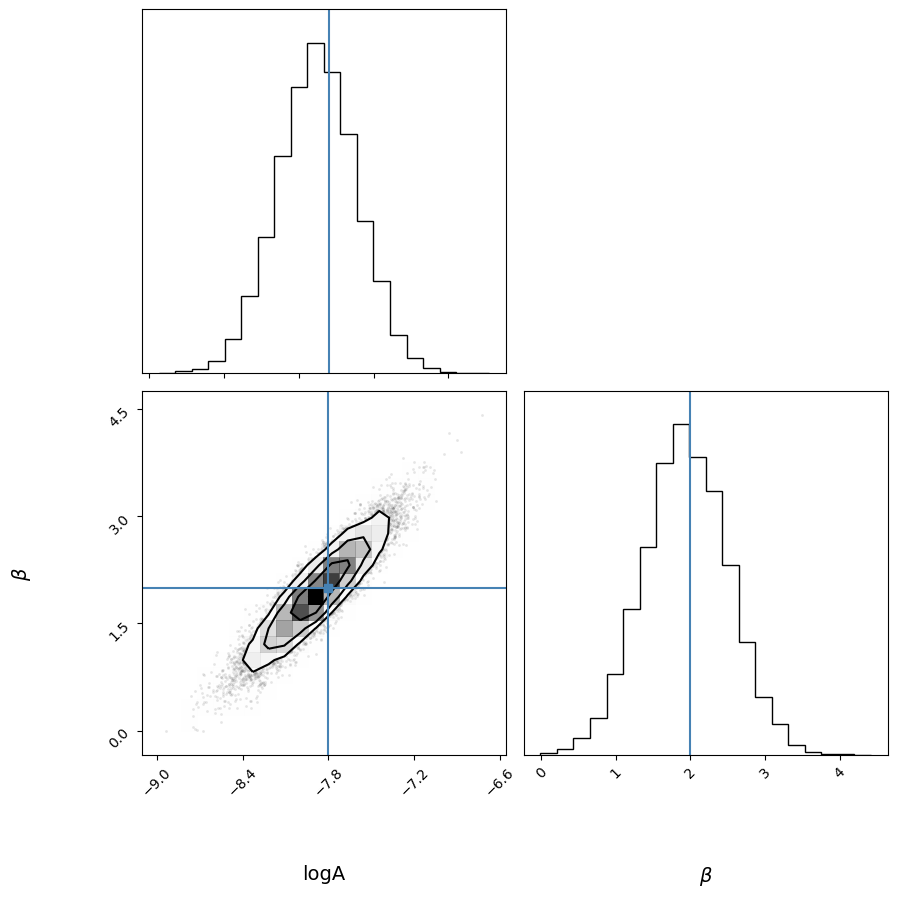

In [42]:
import corner
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(res.x, fisher_matrix, ndraws=10000)

fig = plt.figure(figsize=(10, 10))
fig = corner.corner(samples_fisher, truths=[-7.8,2.], show_titles=False, labels=['logA',r'$\beta$'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()